In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [2]:
from path_overlap import * 

In [3]:
num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
num_layers = 4
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [4]:
pos = nx.multipartite_layout(MPG)

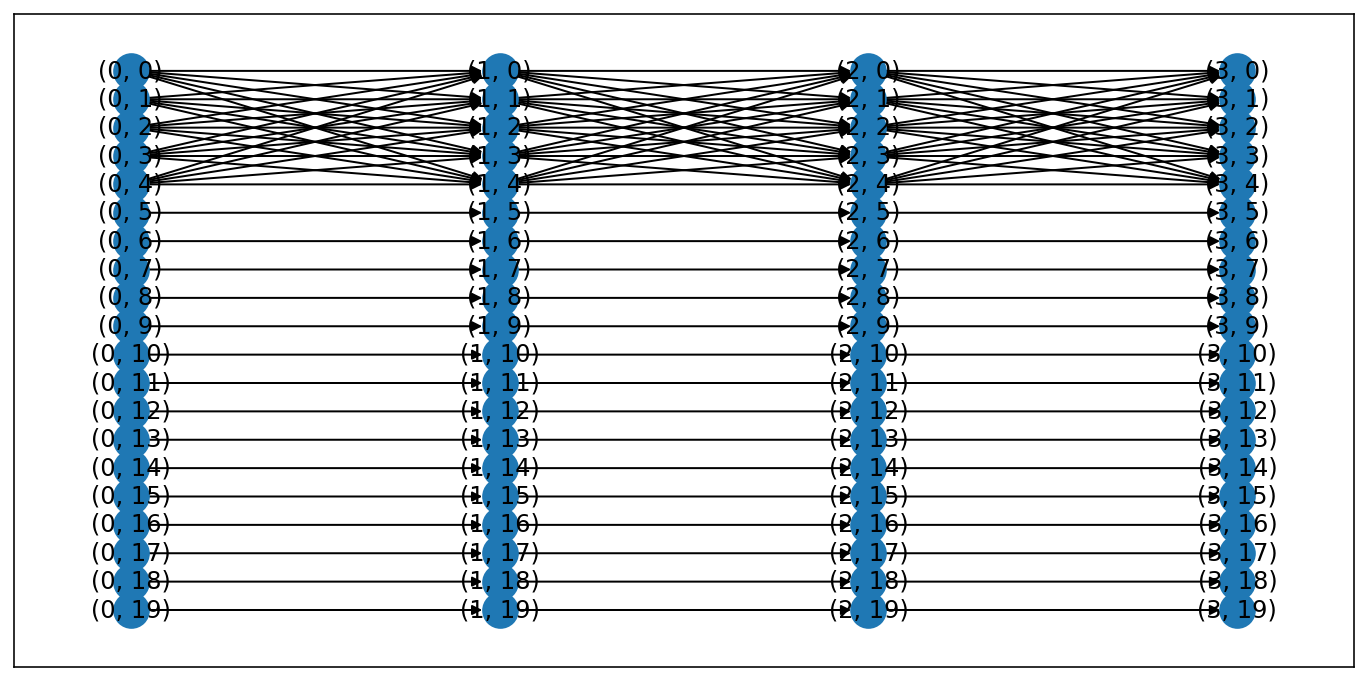

In [5]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [6]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=100)

In [7]:
rew_pos = nx.multipartite_layout(rew_MPG)

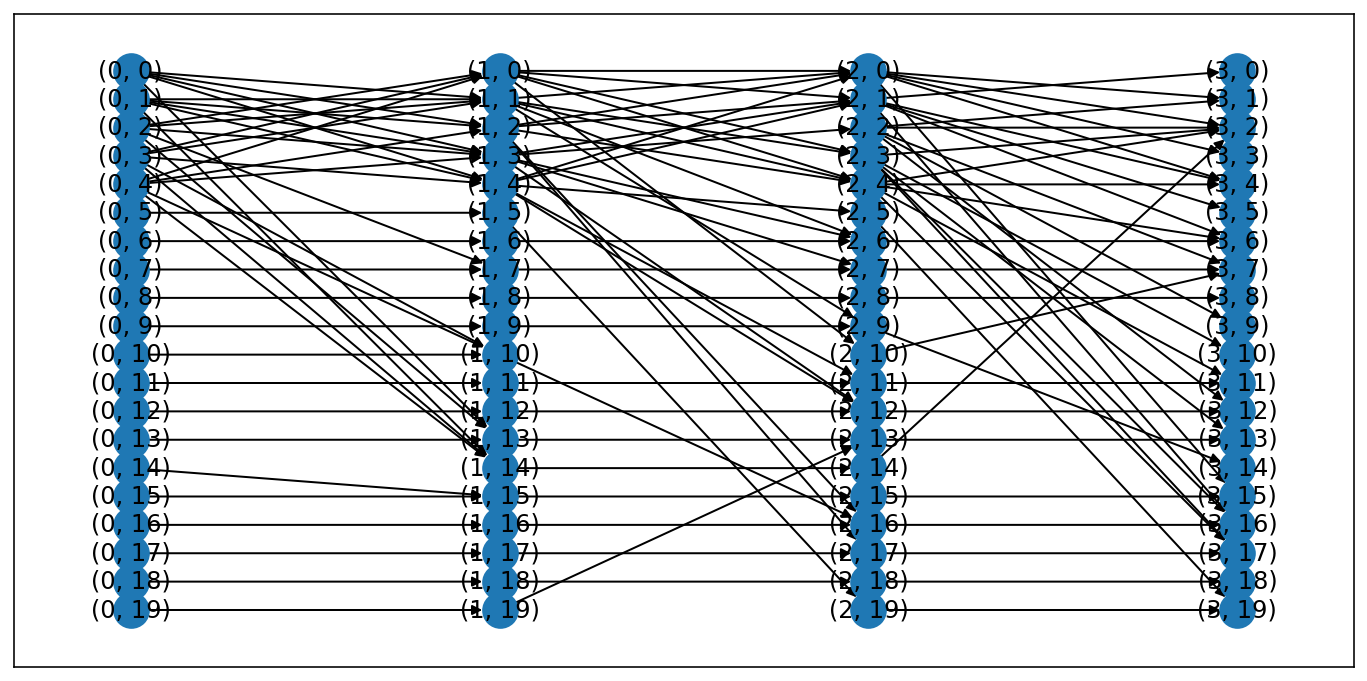

In [8]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [9]:
from itertools import combinations, product
output_nodes = [(num_layers-1, x) for x in range(tot_units)]
input_nodes = [(0, x) for x in range(tot_units)]

paths = {}
for n, nn in product(input_nodes, output_nodes):
    paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
rew_paths = {}
for n, nn in product(input_nodes, output_nodes):
    rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

In [10]:
IG, rew_IG = MP_interference_graph(MPG, paths), MP_interference_graph(rew_MPG, rew_paths)

In [11]:
IG.number_of_edges(), rew_IG.number_of_edges()

(300, 4240)

In [12]:
from networkx.algorithms.flow import shortest_augmenting_path

In [13]:
num_iterations = 30
rw_it = 0.1
independent_paths = {}

num_dense, num_sparse = 5, 15
tot_units = num_dense + num_sparse
density = 1
counts = {}
range_num_layers = [2, 3, 4, 5]
capacity = {}
for nl in tqdm(range_num_layers):
    output_nodes = [(nl-1, x) for x in range(tot_units)]
    input_nodes = [(0, x) for x in range(tot_units)]
    tMPG = multipartite_network(nl, num_dense, num_sparse, density)    
    independent_paths[nl] = {}
    instant_rew_MPG = tMPG.copy()
    instant_paths = {}
    for n, nn in product(input_nodes, output_nodes):
        instant_paths[(n, nn)] = list(nx.all_simple_paths(instant_rew_MPG, n, nn));
        if len(instant_paths[(n,nn)]) == 0:
            del instant_paths[(n,nn)]
    independent_paths[nl][0] = all_flows_MPG(instant_rew_MPG, instant_paths)
    counts[nl] = [0]                                             
    for it in tqdm(range(1, num_iterations)):
        rw_it_num = int(instant_rew_MPG.number_of_edges() * rw_it) 
        instant_rew_MPG, instant_counts = rewire_multipartite_network(
            instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it_num, verbose=True)
        instant_paths = {}
        for n, nn in product(input_nodes, output_nodes):
            instant_paths[(n, nn)] = list(nx.all_simple_paths(instant_rew_MPG, n, nn));
            if len(instant_paths[(n,nn)]) == 0:
                del instant_paths[(n,nn)]
        counts[nl].append(counts[nl][-1]+instant_counts)
        independent_paths[nl][it] = all_flows_MPG(instant_rew_MPG, instant_paths)

In [14]:
instant_rew_MPG.number_of_edges()
len(nx.get_edge_attributes(instant_rew_MPG, 'capacity'))

160

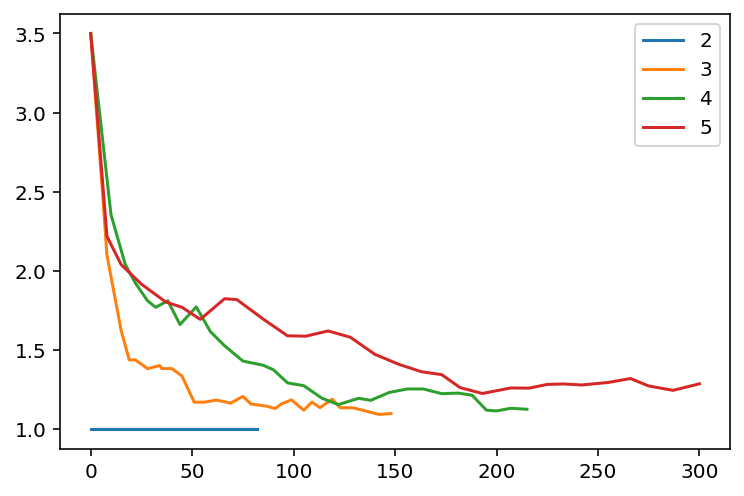

In [21]:
av_num_paths, err_num_paths = {}, {}
for nl in range_num_layers:
    av_num_paths[nl] = [np.nanmean(list(independent_paths[nl][x].values())) for x in range(0, num_iterations)]
#     err_num_paths[nl] = [np.nanstd(list(independent_paths[nl][x].values())) for x in range(0, num_iterations)]
#     plt.errorbar(counts[nl], av_num_paths[nl], err_num_paths[nl], label = nl)
    plt.plot(counts[nl], np.array(av_num_paths[nl]) , label = nl)
plt.legend()